There is the simplest models always predicting a cosnstant for `updrs_1, updrs_2, updrs_3, updrs_4` [Only Constants](https://www.kaggle.com/code/vitalykudelya/only-constants).

Let's complicate the previous model and add trend for the `pred_month` feature (from a model with one paramter we moved to model with two parameters).

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import amp_pd_peptide
from scipy.optimize import minimize
import itertools
from matplotlib import pyplot as plt

In [2]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

In [3]:
class CFG:
    do_opt = True
    remove_high = False

In [4]:
def smape_plus_1(y_true, y_pred):
    y_true_plus_1 = y_true + 1
    y_pred_plus_1 = y_pred + 1
    metric = np.zeros(len(y_true_plus_1))
    
    numerator = np.abs(y_true_plus_1 - y_pred_plus_1)
    denominator = ((np.abs(y_true_plus_1) + np.abs(y_pred_plus_1)) / 2)
    
    mask_not_zeros = (y_true_plus_1 != 0) | (y_pred_plus_1 != 0)
    metric[mask_not_zeros] = numerator[mask_not_zeros] / denominator[mask_not_zeros]
    
    return 100 * np.nanmean(metric)

In [5]:
train_clinical_data = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
train_clinical_data['source'] = 'standard'

supplemental_clinical_data = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv')
supplemental_clinical_data['source'] = 'supplemental'

train_clinical_all = pd.concat([train_clinical_data, supplemental_clinical_data])

## Plots of y_true

In [6]:
for target in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
    fig = px.box(
        train_clinical_all, 
        y=target, 
        x='visit_month', 
        color='source', 
        title=f'{target} per visit_month'
    )
    fig.show()
    
    fig = px.histogram(
        train_clinical_all, 
        x=target, 
        color='source', 
        title=f'{target} Distribution', 
        histnorm='probability', 
        barmode='overlay'
    )
    fig.show()

In [7]:
train_clinical_all.groupby('patient_id').describe().reset_index(drop = False)

patient_id visit_month                                                \
                      count       mean        std  min   25%   50%    75%   
0            35         2.0  18.000000  25.455844  0.0  9.00  18.0  27.00   
1            55        13.0  26.307692  20.315776  0.0  9.00  24.0  42.00   
2            75         2.0  18.000000  25.455844  0.0  9.00  18.0  27.00   
3           155         1.0   0.000000        NaN  0.0  0.00   0.0   0.00   
4           337         2.0  18.000000  25.455844  0.0  9.00  18.0  27.00   
...         ...         ...        ...        ...  ...   ...   ...    ...   
1014      65290         5.0  14.400000  12.441865  0.0  6.00  12.0  24.00   
1015      65303         2.0  18.000000  25.455844  0.0  9.00  18.0  27.00   
1016      65382         1.0   0.000000        NaN  0.0  0.00   0.0   0.00   
1017      65405         2.0   2.500000   3.535534  0.0  1.25   2.5   3.75   
1018      65530         2.0  18.000000  25.455844  0.0  9.00  18.0  27.00   

           updrs_1                                                      \
       max   count       mean       std  min    25%   50%    75%   max   
0     36.0     2.0   5.500000  0.707107  5.0   5.25   5.5   5.75   6.0   
1     60.0    13.0  12.615385  4.610467  7.0  10.00  12.0  16.00  23.0   
2     36.0     2.0   2.500000  2.121320  1.0   1.75   2.5   3.25   4.0   
3      0.0     0.0        NaN       NaN  NaN    NaN   NaN    NaN   NaN   
4     36.0     2.0   6.500000  2.121320  5.0   5.75   6.5   7.25   8.0   
...    ...     ...        ...       ...  ...    ...   ...    ...   ...   
1014  30.0     5.0   3.000000  1.414214  1.0   2.00   4.0   4.00   4.0   
1015  36.0     2.0   2.000000  2.828427  0.0   1.00   2.0   3.00   4.0   
1016   0.0     0.0        NaN       NaN  NaN    NaN   NaN    NaN   NaN   
1017   5.0     1.0   5.000000       NaN  5.0   5.00   5.0   5.00   5.0   
1018  36.0     2.0   9.000000  1.414214  8.0   8.50   9.0   9.50  10.0   

     updrs_2                                                      updrs_3  \
       count       mean       std   min    25%   50%    75%   max   count   
0        2.0   3.500000  0.707107   3.0   3.25   3.5   3.75   4.0     2.0   
1       13.0  13.076923  5.057363   6.0   9.00  13.0  18.00  21.0    13.0   
2        2.0   7.000000  1.414214   6.0   6.50   7.0   7.50   8.0     2.0   
3        0.0        NaN       NaN   NaN    NaN   NaN    NaN   NaN     1.0   
4        2.0   7.000000  0.000000   7.0   7.00   7.0   7.00   7.0     2.0   
...      ...        ...       ...   ...    ...   ...    ...   ...     ...   
1014     5.0  13.800000  1.483240  12.0  13.00  14.0  14.00  16.0     5.0   
1015     2.0   1.500000  0.707107   1.0   1.25   1.5   1.75   2.0     2.0   
1016     0.0        NaN       NaN   NaN    NaN   NaN    NaN   NaN     1.0   
1017     1.0  16.000000       NaN  16.0  16.00  16.0  16.00  16.0     2.0   
1018     2.0   5.000000  1.414214   4.0   4.50   5.0   5.50   6.0     2.0   

                                                           updrs_4            \
           mean        std   min    25%   50%    75%   max   count      mean   
0     18.000000   2.828427  16.0  17.00  18.0  19.00  20.0     2.0  0.000000   
1     40.923077  12.196048  15.0  34.00  41.0  51.00  56.0    10.0  0.000000   
2     32.000000   8.485281  26.0  29.00  32.0  35.00  38.0     2.0  0.000000   
3      0.000000        NaN   0.0   0.00   0.0   0.00   0.0     0.0       NaN   
4      7.000000   1.414214   6.0   6.50   7.0   7.50   8.0     2.0  0.000000   
...         ...        ...   ...    ...   ...    ...   ...     ...       ...   
1014  16.000000   3.937004  13.0  13.00  14.0  18.00  22.0     3.0  0.666667   
1015  23.000000   4.242641  20.0  21.50  23.0  24.50  26.0     2.0  0.000000   
1016   0.000000        NaN   0.0   0.00   0.0   0.00   0.0     0.0       NaN   
1017  44.000000  18.384776  31.0  37.50  44.0  50.50  57.0     1.0  0.000000   
1018  19.500000   6.363961  15.0  17.25  19.5  21.75  24.0     2.0  2.000000  

In [8]:
train_clinical_all['visit_month'].unique()

array([  0,   3,   6,   9,  12,  18,  24,  30,  36,  42,  48,  54,  60,
        72,  84,  96, 108,   5])

In [9]:
count_patient = pd.DataFrame(train_clinical_all['patient_id'].value_counts()).reset_index(drop = False)
count_patient.columns = ['patient_id', 'patient_count']
use_patient = count_patient[count_patient['patient_count'] >= 3]['patient_id'].unique()
use_patient[:5]

array([55096, 57108, 15009, 44789, 16778])

In [10]:
target_max_dict = {
    'updrs_1':{},
    'updrs_2':{},
    'updrs_3':{},
    'updrs_4':{},
}

In [11]:
for i in range(1, 5):
    target = f'updrs_{i}'
    updrs_max_df = train_clinical_all.groupby('visit_month')[target].describe(percentiles = [0.95]).reset_index(drop = False)
    updrs_max_dict = dict(updrs_max_df[updrs_max_df['95%'].notnull()][['visit_month', '95%']].values)
    target_max_dict[target] = updrs_max_dict
print(target_max_dict)

{'updrs_1': {0.0: 14.0, 3.0: 15.299999999999997, 6.0: 16.0, 9.0: 16.0, 12.0: 14.0, 18.0: 15.0, 24.0: 16.0, 30.0: 16.0, 36.0: 16.0, 42.0: 18.400000000000006, 48.0: 19.25, 54.0: 22.099999999999994, 60.0: 20.0, 72.0: 18.39999999999999, 84.0: 19.049999999999997, 96.0: 18.15, 108.0: 24.949999999999992}, 'updrs_2': {0.0: 15.0, 3.0: 18.299999999999997, 6.0: 17.0, 9.0: 18.14999999999999, 12.0: 15.0, 18.0: 17.0, 24.0: 17.0, 30.0: 18.0, 36.0: 18.0, 42.0: 20.0, 48.0: 20.25, 54.0: 21.549999999999997, 60.0: 19.0, 72.0: 19.0, 84.0: 23.049999999999997, 96.0: 21.0, 108.0: 21.949999999999992}, 'updrs_3': {0.0: 40.0, 3.0: 39.349999999999994, 5.0: 58.14999999999999, 6.0: 42.0, 9.0: 37.29999999999998, 12.0: 43.0, 18.0: 42.0, 24.0: 45.0, 30.0: 44.0, 36.0: 46.0, 42.0: 49.0, 48.0: 46.0, 54.0: 46.19999999999999, 60.0: 48.75, 72.0: 49.5, 84.0: 53.89999999999999, 96.0: 55.0, 108.0: 46.45}, 'updrs_4': {0.0: 6.7999999999999545, 3.0: 0.6999999999999993, 5.0: 8.599999999999998, 6.0: 7.849999999999994, 9.0: 3.899999

In [12]:
if CFG.remove_high:

    for i in range(1, 5):
        target = f'updrs_{i}'
        for change_visit in target_max_dict[target].keys():

            train_clinical_all.loc[
                (train_clinical_all['visit_month'] == change_visit)
                &(train_clinical_all[target] >= target_max_dict[target][change_visit]), 
                target
            ] = target_max_dict[target][change_visit]

It's interesting that for supplemental_data `max(visit_month) = 36`, for standard data we have much more visit_months. Distributions of **y_true** are also different. <br>
Additionally we cand find a little trend. <br>

In [13]:
# delete visit_month 3, 5, 9 (there are no such visit_months in the Test API)
train_clinical_all = train_clinical_all[~train_clinical_all.visit_month.isin([3, 5, 9])]

In [14]:
# 追加
# train_clinical_all = train_clinical_all[train_clinical_all['source']=='standard']

In [15]:
# 追加
# train_clinical_all = train_clinical_all[train_clinical_all['patient_id'].isin(use_patient)]

## Create Train Dataset

More detailed information why we use only plus 6, 12, 24 months of **y_true** and other mechanics of this competition could be found in the notebook [Explain Dataset, Test API, Cross-Validation Tips](https://www.kaggle.com/code/vitalykudelya/explain-dataset-test-api-cross-validation-tips).

In [16]:
train_clinical_all['pred_month'] = train_clinical_all['visit_month']

for plus_month in [6, 12, 24]:
    train_shift = train_clinical_all[['patient_id', 'visit_month', 'pred_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].copy()
    train_shift['visit_month'] -= plus_month
    train_shift.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_{plus_month}' for i in range(1, 5)}, inplace=True)
    train_shift.rename(columns={'pred_month': f'pred_month_plus_{plus_month}'}, inplace=True)
    train_clinical_all = train_clinical_all.merge(train_shift, how='left', on=['patient_id', 'visit_month'])

train_clinical_all.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_0' for i in range(1, 5)}, inplace=True)
train_clinical_all.rename(columns={'pred_month': f'pred_month_plus_0'}, inplace=True)
train_clinical_all

,visit_id,patient_id,visit_month,updrs_1_plus_0,updrs_2_plus_0,updrs_3_plus_0,updrs_4_plus_0,upd23b_clinical_state_on_medication,source,pred_month_plus_0,pred_month_plus_6,updrs_1_plus_6,updrs_2_plus_6,updrs_3_plus_6,updrs_4_plus_6,pred_month_plus_12,updrs_1_plus_12,updrs_2_plus_12,updrs_3_plus_12,updrs_4_plus_12,pred_month_plus_24,updrs_1_plus_24,updrs_2_plus_24,updrs_3_plus_24,updrs_4_plus_24
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,standard,0,6.0,8.0,10.0,34.0,NaN,12.0,10.0,10.0,41.0,0.0,24.0,16.0,9.0,49.0,0.0
1,55_6,55,6,8.0,10.0,34.0,NaN,NaN,standard,6,12.0,10.0,10.0,41.0,0.0,18.0,7.0,13.0,38.0,0.0,30.0,14.0,13.0,49.0,0.0
2,55_12,55,12,10.0,10.0,41.0,0.0,On,standard,12,18.0,7.0,13.0,38.0,0.0,24.0,16.0,9.0,49.0,0.0,36.0,17.0,18.0,51.0,0.0
3,55_18,55,18,7.0,13.0,38.0,0.0,On,standard,18,24.0,16.0,9.0,49.0,0.0,30.0,14.0,13.0,49.0,0.0,42.0,12.0,20.0,41.0,0.0
4,55_24,55,24,16.0,9.0,49.0,0.0,On,standard,24,30.0,14.0,13.0,49.0,0.0,36.0,17.0,18.0,51.0,0.0,48.0,17.0,16.0,52.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4501,65303_36,65303,36,4.0,1.0,26.0,0.0,NaN,supplemental,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4502,65382_0,65382,0,NaN,NaN,0.0,NaN,NaN,supplemental,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4503,65405_0,65405,0,5.0,16.0,31.0,0.0,NaN,supplemental,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4504,65530_0,65530,0,10.0,6.0,24.0,0.0,NaN,supplemental,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Find the best trend

In [17]:
def calculate_predicitons(pred_month, trend):
    if target == 'updrs_4': 
        pred_month = pred_month.clip(54, None)
    return np.round(trend[0] + pred_month * trend[1])

def function_to_minimize(x):    
    metric = smape_plus_1(
        y_true=y_true_array, 
        y_pred=calculate_predicitons(
            pred_month=pred_month_array,
            trend=x
        )
    )
    return metric


if CFG.do_opt == True:
    target_to_trend = {}

    for i in range(1, 5):
        target = f'updrs_{i}'
        score = 10000

        print(f'{target}started!!!!***************************************')

        columns_with_target = [f'{target}_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
        columns_with_pred_month = [f'pred_month_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
        y_true_array = train_clinical_all[columns_with_target].values.ravel()
        pred_month_array = train_clinical_all[columns_with_pred_month].values.ravel()
        
        for coef1, coef2 in itertools.product(
            [0, 0.001, 0.0048, 0.005, 0.01, 0.05, 0.1, 1], 
            [0, 0.001, 0.0048, 0.005, 0.01, 0.05, 0.1, 1]
        ):

            trend = list(minimize(
                fun=function_to_minimize,
                x0=[coef1, coef2],
                method='Powell'
            ).x)

            y_trend_pred_array = calculate_predicitons(pred_month_array, trend)
#             y_trend_pred_array = np.round(trend[0] + trend[1] * pred_month_array)
            
            tmp_score = smape_plus_1(y_true_array, y_trend_pred_array)

            if tmp_score <= score:
                target_to_trend[target] = trend
                score = tmp_score
                print(trend)
                print(tmp_score)
        print(f'optimized_trend:{target_to_trend[target]}')
        print('*'*80)
        print('*'*80)
        print('*'*80)
        print('*'*80)
else:
    pass

target_to_trend['updrs_4'] = [-4.434453480103724, 0.07531448585334258]  

scores = []
for i in range(1, 5):
    target = f'updrs_{i}'
    score = 10000

    columns_with_target = [f'{target}_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
    columns_with_pred_month = [f'pred_month_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
    y_true_array = train_clinical_all[columns_with_target].values.ravel()
    pred_month_array = train_clinical_all[columns_with_pred_month].values.ravel()
    y_trend_pred_array = calculate_predicitons(pred_month_array, target_to_trend[target])
    tmp_score = smape_plus_1(y_true_array, y_trend_pred_array)

    score = smape_plus_1(y_true_array, y_trend_pred_array)
    scores.append(score)
    print(target, score)
    
print('mean_score', sum(scores)/len(scores))

updrs_1started!!!!***************************************
[5.50796926755269, 3.0102827479992464e-11]
55.24661844792437
[6.440948593796269, 0.0018345982602322305]
55.0209475896854
[5.394793062665313, 0.027091086167821344]
55.00886399205792
[5.394793062660599, 0.02729108616780187]
55.00886399205792
[4.734213945755918, 0.043987185526034]
54.8695216746128
[5.017342866904237, 0.03793588279845762]
54.8695216746128
[4.737197762305148, 0.04406810365485008]
54.8695216746128
[5.021142866904237, 0.03793588279845762]
54.8695216746128
[4.856239888295906, 0.04084221599291588]
54.8695216746128
[5.021342866904236, 0.03793588279845762]
54.8695216746128
[4.856439888295905, 0.04084221599291588]
54.8695216746128
[4.86287868218834, 0.0392996572092478]
54.8695216746128
[5.026342866904237, 0.03773588279845762]
54.8695216746128
[5.069663560845211, 0.03480012196679531]
54.86893351900044
optimized_trend:[5.069663560845211, 0.03480012196679531]
********************************************************************

In [18]:
target_to_trend

{'updrs_1': [5.069663560845211, 0.03480012196679531],
 'updrs_2': [4.932927377561229, 0.04267552599462405],
 'updrs_3': [19.762037079411606, 0.1309360847988586],
 'updrs_4': [-4.434453480103724, 0.07531448585334258]}

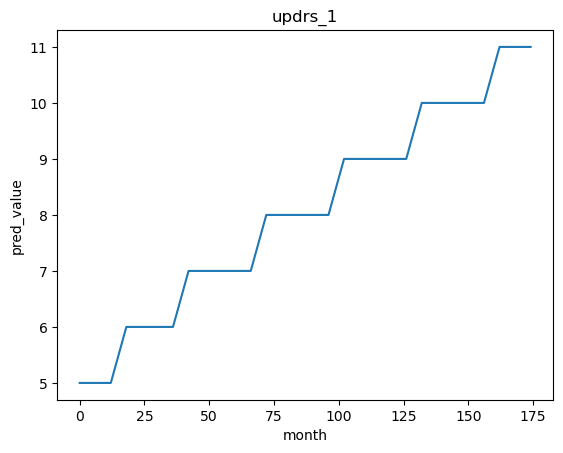

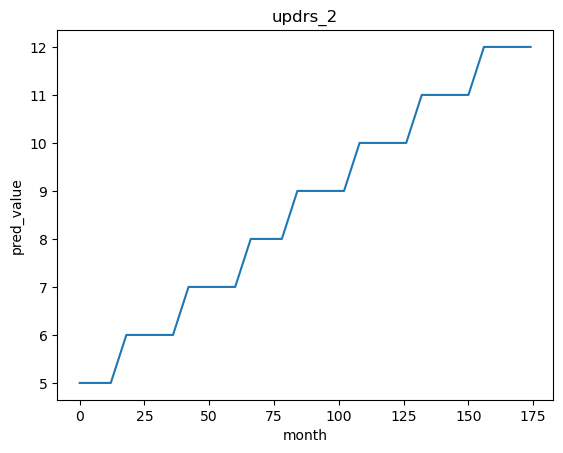

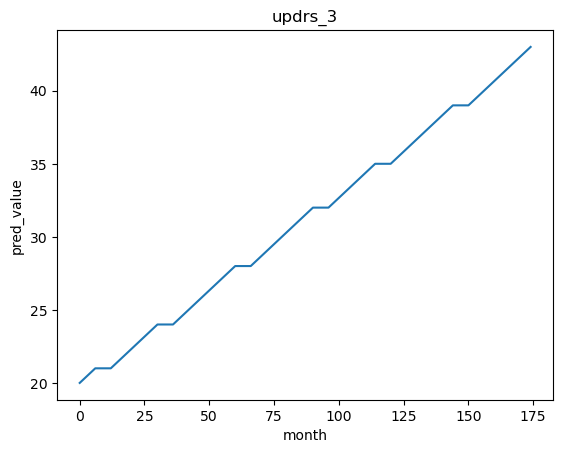

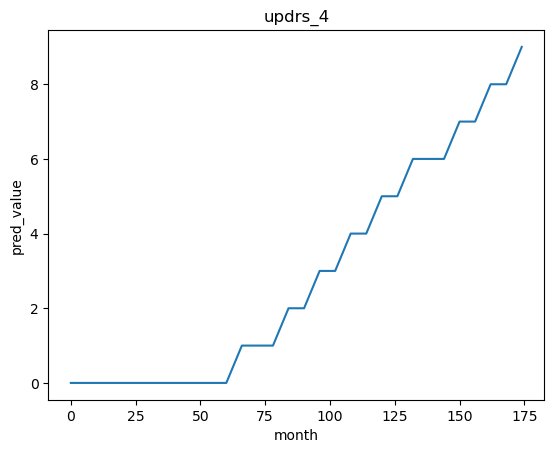

In [19]:
vis_month = np.arange(0, 180, 6)

for i in range(1, 5):
    target = f'updrs_{i}'
    vis_pred = calculate_predicitons(vis_month, target_to_trend[target])
    plt.plot(vis_month, vis_pred)
    plt.title(target)
    plt.xlabel('month')
    plt.ylabel('pred_value')
    plt.show()

In [20]:
# updrs_1 54.96819694092983
# updrs_2 64.95413055630898
# updrs_3 59.13478794861526
# updrs_4 180.80363348799403

In [21]:
# It's possible to find the minimum (not guaranteed) of any other function with this approach
# (replace the function_to_minimize and x can be an array)

`target_to_tred` is our "model" which basically consists of the best linear model (`pred_month` as the only feature) for our train data for each **y_true** (updrs_1, updrs_2, updrs_3, updrs_4).

## Prediction

In [22]:
amp_pd_peptide.make_env.func_dict['__called__'] = False
env = amp_pd_peptide.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files

# The API will deliver four dataframes in this specific order:
for test_clinical_data, test_peptides, test_proteins, sample_submission in iter_test:
    sample_submission['patient_id'] = sample_submission['prediction_id'].map(lambda x: int(x.split('_')[0]))
    sample_submission['visit_month'] = sample_submission['prediction_id'].map(lambda x: int(x.split('_')[1]))
    sample_submission['target_name'] = sample_submission['prediction_id'].map(lambda x: 'updrs_' + x.split('_')[3])
    sample_submission['plus_month'] = sample_submission['prediction_id'].map(lambda x: int(x.split('_')[5]))
    sample_submission['pred_month'] = sample_submission['visit_month'] + sample_submission['plus_month']
    
    for i in range(1, 5):
        target = f'updrs_{i}'
        mask_target = sample_submission['target_name'] == target
        sample_submission.loc[mask_target, 'rating'] = calculate_predicitons(
            pred_month=sample_submission.loc[mask_target, 'pred_month'],
            trend=target_to_trend[target]
        )
        
    sample_submission['rating'] = np.where(sample_submission['rating'] < 0, 0, sample_submission['rating'])
        
    # call the env.predict for every iteration
    env.predict(sample_submission[['prediction_id', 'rating']])

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
